# Viscoelasticity with state variables
In this example, we will use a generalization of the so-called
Zener viscoelastic material model, which can be illustrated by
the following rheological model

![Zener](zener.svg)

We assume a volumetric-deviatoric split of the strain,
and consider isotropic behavior, such that the model
can be described as
$$
\begin{aligned}
\boldsymbol{\sigma} &= \boldsymbol{\sigma}^\mathrm{vol} + \boldsymbol{\sigma}^\mathrm{dev} \\
\boldsymbol{\sigma}^\mathrm{vol} &= 3K\boldsymbol{\epsilon}^\mathrm{vol}\\
\boldsymbol{\sigma}^\mathrm{dev} &= 2G_1 \boldsymbol{\epsilon}^\mathrm{dev} + 2G_2 \boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{e} \\
2G_2 \boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{e} &= \eta \dot{\boldsymbol{\epsilon}}_\mathrm{v}^\mathrm{dev} \\
\boldsymbol{\epsilon}^\mathrm{dev} &= \boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{e} + \boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{v}
\end{aligned}
$$
where we have the bulk modulus, $K$, shear modulii $G_1$ and $G_2$ (such that $\mathsf{E}_i=2G_i\mathsf{I}^\mathrm{dev}$),
and viscosity $\eta$ (such that $\mathsf{V}=\eta\mathsf{I}$)
Solving this equation system using the old viscous strain, $\boldsymbol{\epsilon}^\mathrm{dev}$, as a state variable,
we obtain
$$
\begin{aligned}
\boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{v} &=
\frac{2\Delta t*G_2*\boldsymbol{\epsilon}^\mathrm{dev} + \eta {}^\mathrm{n}\boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{v}}{\eta + 2\Delta t G_2} \\
\boldsymbol{\sigma} &= 3 K \boldsymbol{\epsilon}^\mathrm{vol} + 2G_1 \boldsymbol{\epsilon}^\mathrm{dev} + 2G_2 [\boldsymbol{\epsilon}^\mathrm{dev}-\boldsymbol{\epsilon}^\mathrm{dev}_\mathrm{v}]
\end{aligned}
$$

The full script without intermediate comments is available at the
bottom of this page.

We start by loading required packages

In [1]:
using Ferrite, Tensors
using FerriteAssembly
import CairoMakie as CM

## Material modeling
The easiest way to implement this behavior, would be to use the existing interface from
[MaterialModelsBase.jl](https://github.com/KnutAM/MaterialModelsBase.jl). But for the purpose
of this tutorial, we will do it from scratch to show how to handle state variables in the
finite element code. To start the material modeling, we define a material struct with all
parameters.

In [2]:
Base.@kwdef struct ZenerMaterial{T}
    K::T =5.0/3 # Bulk modulus
    G1::T=1.0   # Shear modulus, parallel
    G2::T=50.   # Shear modulus, series
    η::T =5.0   # Damping modulus
end;

We then define how to the initial state variables should look like, which also defines the structure
of the state variables. In this case, we will just have states being a single tensor (viscous strain)
for each integration point

In [3]:
function FerriteAssembly.create_cell_state(::ZenerMaterial, cv::AbstractCellValues, args...)
    ϵ_template = shape_symmetric_gradient(cv, 1, 1) # ::SymmetricTensor
    return [zero(ϵ_template) for _ in 1:getnquadpoints(cv)]
end;

Following this, we define the `element_residual!` function (we will use automatic differentiation
to calculate the element stiffness).

In [4]:
function FerriteAssembly.element_residual!(re, state, ae, m::ZenerMaterial, cv::AbstractCellValues, buffer)
    Δt = FerriteAssembly.get_time_increment(buffer)
    old_ϵvs = FerriteAssembly.get_old_state(buffer)
    for q_point in 1:getnquadpoints(cv)
        old_ϵv = old_ϵvs[q_point]
        dΩ = getdetJdV(cv, q_point)
        ϵ = function_symmetric_gradient(cv, q_point, ae)
        ϵdev = dev(ϵ)
        ϵv = (Δt * 2 * m.G2 * ϵdev + m.η * old_ϵv)/(m.η + Δt * 2 * m.G2)
        σ = (m.G1 + m.G2) * 2 * ϵdev - 2 * m.G2 * ϵv + 3 * m.K * vol(ϵ)
        for i in 1:getnbasefunctions(cv)
            δ∇N = shape_symmetric_gradient(cv, q_point, i)
            re[i] += (δ∇N ⊡ σ) * dΩ
        end
        # We only want to save the value-part of the states, and FerriteAssembly comes with
        # the utility `FerriteAssembly.remove_dual` to do so for scalars and Tensors.
        # Note that using `state[q_point]` instead of ϵv for any calculations
        # affecting re, will result in wrong derivatives.
        state[q_point] = FerriteAssembly.remove_dual(ϵv)
    end
end;

## Finite element setup
To setup our problem, we use a simple grid and define all interpolations, quadrature rules,
etc. as normally for `Ferrite` simulations. We also define the `Zener` material and create the
domain buffer.

In [5]:
grid = generate_grid(Quadrilateral, (20, 20))
ip = geometric_interpolation(Quadrilateral)
dh = DofHandler(grid)
add!(dh, :u, ip^2)
close!(dh)
qr = QuadratureRule{RefQuadrilateral}(2)
cv = CellValues(qr, ip^2, ip)
m = ZenerMaterial()
domain = DomainSpec(dh, m, cv)
buffer = setup_domainbuffer(domain; autodiffbuffer=true);

Fix left side of beam, vertical load on right side.

In [6]:
ch = ConstraintHandler(dh)
add!(ch, Dirichlet(:u, getfacetset(grid, "left"), Returns(zero(Vec{2}))))
close!(ch)
update!(ch, 0.0);

We use `FerriteAssembly`'s `LoadHandler` to apply the Neumann boundary conditions,
which consist of a ramp followed by a hold.

In [7]:
lh = LoadHandler(dh)
traction(t) = clamp(t, 0, 1)*Vec((0.0, 1.0))
add!(lh, Neumann(:u, 2, getfacetset(grid, "right"), (x, t, n) -> traction(t)));

## Finite element solution
Given this setup, we define a function that steps through the time history,
and for each time step, iterates to find the correct solution. After convergence,
we update the state variables.

In [8]:
function solve_nonlinear_timehistory(buffer, dh, ch, lh; time_history)
    maxiter = 10
    tolerance = 1e-6
    K = allocate_matrix(dh)
    r = zeros(ndofs(dh))
    f = zeros(ndofs(dh))
    a = zeros(ndofs(dh))
    t_force = [0.0]
    u1_max = [0.0]
    told = 0.0
    for t in time_history
        # Update and apply the Dirichlet boundary conditions
        update!(ch, t)
        apply!(a, ch)
        # Update and apply the Neumann boundary conditions
        fill!(f, 0)
        apply!(f, lh, t)
        # Update the time increment (passed to `element_residual!`)
        set_time_increment!(buffer, t-told)
        for i in 1:maxiter
            # Assemble the system
            assembler = start_assemble(K, r)
            work!(assembler, buffer; a=a)
            r .-= f
            # Apply boundary conditions
            apply_zero!(K, r, ch)
            # Check convergence
            norm(r) < tolerance && break
            i == maxiter && error("Did not converge")
            # Solve the linear system and update the dof vector
            a .-= K\r
            apply!(a, ch) # Make sure Dirichlet BC are exactly fulfilled
        end
        # If converged, update the old state variables to the current.
        update_states!(buffer)

        # Save values for postprocessing
        push!(t_force, norm(traction(t)))
        push!(u1_max, maximum(a))
        told = t
    end
    return u1_max, t_force
end;

Define a time history with uneven time steps (shorter in the beginning)

In [9]:
time_history = collect(range(0,1,10)).^2
append!(time_history, 1 .+ collect(range(0,1,10)[2:end]).^2)

u1_max, t_force = solve_nonlinear_timehistory(buffer, dh, ch, lh; time_history=time_history[2:end]);

## Plot the results

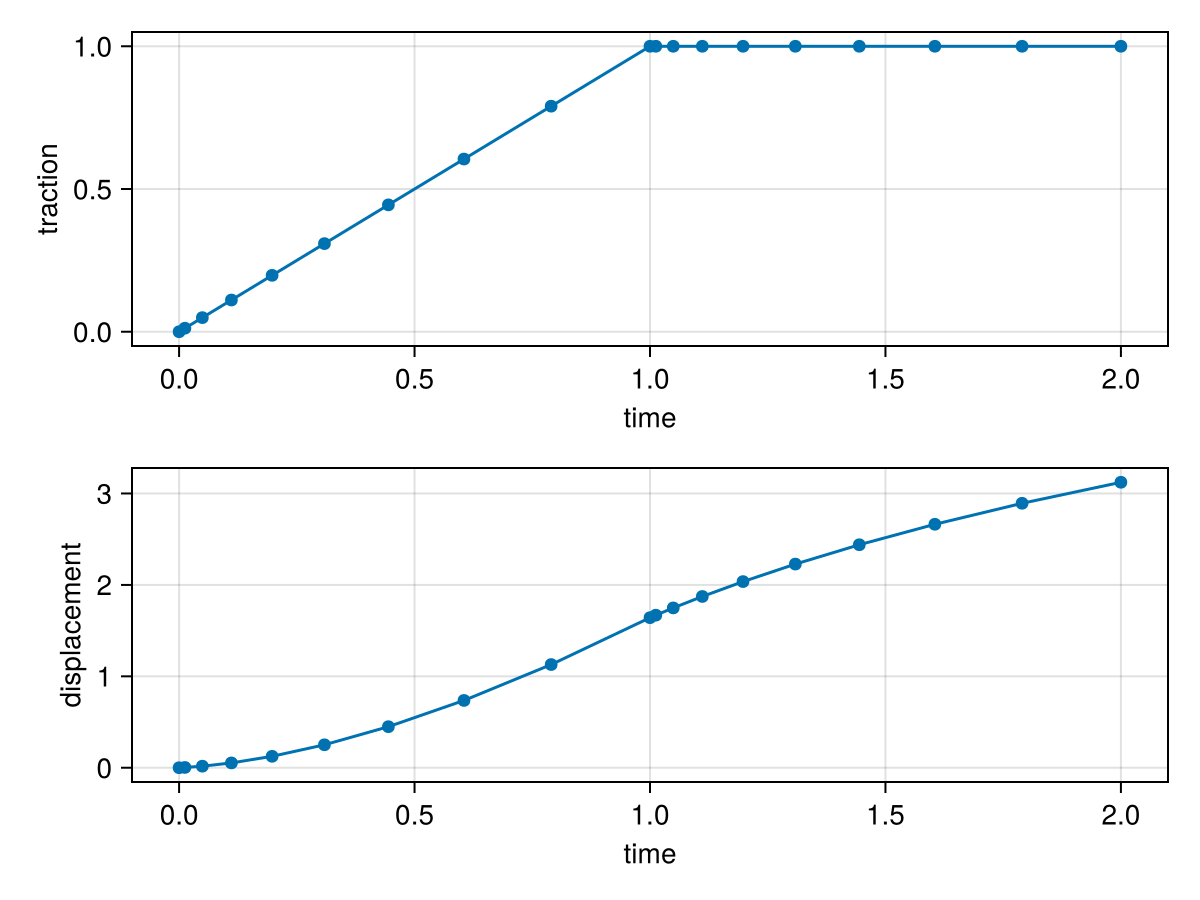

In [10]:
fig = CM.Figure()
ax_t = CM.Axis(fig[1,1]; xlabel="time", ylabel="traction")
ax_d = CM.Axis(fig[2,1]; xlabel="time", ylabel="displacement")
CM.lines!(ax_t, time_history, t_force)
CM.scatter!(ax_t, time_history, t_force)
CM.lines!(ax_d, time_history, u1_max)
CM.scatter!(ax_d, time_history, u1_max)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*